# Capstone Webscrapping using BeautifulSoup

Notebook ini adalah kerangka untuk visualisasi projek Capstone Data Analytics yang diberikan oleh Algoritma Academy. Seperti yang tertulis pada title, case yang diambil dan dibahas pada notebook ini adalah case Webscraping. 

## background

Soal yang diambil pada case ini adalah tentang pergerakan harga kurs USD-IDR selama 6 bulan terakhir. Informasi tentang kurs didapatkan dari situs https://www.exchange-rates.org/exchange-rate-history/usd-idr, yang kemudian akan divisualisasikan dengan menggunakan plot sederhana. Informasi yang didapatkan dari visualisasi diharapkan dapat membantu memberikan insight kepada user mengenai kondisi ekonomi Indonesia pada saat ini, apakah sedang membaik atau justru memburuk?

Informasi tentang kurs USD-IDR dapat dijadikan pengukuran kondisi ekonomi Indonesia dengan pertanyaan sebagai berikut: Seberapa banyak Rupiah yang bisa dibeli dengan $1? Semakin tinggi Rupiah yang bisa dibeli menandakan bahwa Rupiah sedang melemah, sedangkan jika tidak banyak maka menandakan Rupiah sedang menguat. Dari informasi tersebut, kita bisa melihat dua hal

- Seberapa besar buying power Indonesia jika negara kita melakukan transaksi dengan USD?
- Bagaimana kondisi inflasi di Indonesia?

## Requesting the Data and Creating a BeautifulSoup

Langkah pertama yang dapat kita lakukan untuk menarik informasi adalah dengan menggunakan fungsi `.get()` dari package requests, yang dimana kita cukup memasukkan link situs ke dalam fungsi

In [1]:
import requests

url_get = requests.get('https://www.exchange-rates.org/history/IDR/USD/T')

Setelah itu, kita perlu memastikan bahwa kita sudah mendapatkan situs yang ingin kita scrap. Caranya cukup dengan menggunakan fungsi `.content`, yang dimana fungsi tersebut menunjukkan komponen-komponen pada situs, contohnya informasi doctype yang berada pada situs. Pada kasus ini, doctype dari situs adalah HTML. Kita dapat memastikan informasi tersebut memang benar ada pada situs dengan melakukan inspect element pada situs.

In [2]:
url_get.content[1:500]

b'!DOCTYPE html>\r\n<!--[if lt IE 9]>\r\n<html class="no-js ie8 oldie" lang="en" xml:lang=\'en\'>\r\n<![endif]-->\r\n<!--[if gt IE 8]><!--><html class="no-js" lang="en" xml:lang=\'en\'><!--<![endif]-->\r\n<head>\r\n<title>USD to IDR exchange rate history</title>\r\n<meta http-equiv="X-UA-Compatible" content="IE=edge">\r\n<meta name="viewport" content="width=device-width, initial-scale=1, maximum-scale=5">\r\n<meta charset="utf-8" /><meta http-equiv="Content-Type" content="text/html; charset=utf-8" />\r\n<base href="http'

Setelah kita memastikan bahwa kita sudah melakukan scraping terhadap situs yang benar, kita dapat menggunakan fungsi `BeautifulSoup()` untuk mengubah dokumen HTML yang kita miliki saat ini menjadi objek bahasa Python, sehingga memungkinkan kita untuk mengolah data HTML dengan bahasa Python

Penggunaan fungsi `BeautifulSoup()` dilakukan pada cell berikut:

In [3]:
from bs4 import BeautifulSoup 

soup = BeautifulSoup(url_get.content,"html.parser")

## Finding the right key to scrap the data & Extracting the right information

Setelah membuat HTML situs menjadi bisa diolah dengan Python, langkah selanjutnya adalah untuk mencari bagian dari dokumen HTML yang bisa kita tarik untuk membuat visualisasi. Pada situs tersebut terdapat tabel informasi yang menunjukkan tanggal dan harga kurs USD-IDR pada tanggal tersebut. Kita bisa memanfaatkan table tersebut untuk membentuk visualisasi kita.

Melalui inspect element, ditemukan bahwa key yang mengandung informasi tentang isi tabel adalah "tbody". Kita dapat menggunakan fungsi `.find()` untuk menarik informasi tersebut. Hasil `.find` akan diassign kepada "table", yang kemudian akan dijalankan fungsi `prettify()`. Fungsi `prettify()` dapat digunakan untuk dua hal:
 - Sebagai konfirmasi mengenai apakah data yang kita inginkan berhasil di extract atau tidak.
 - Menunjukkan lokasi key untuk isi sebuah tabel. Pada kasus ini, berarti setiap tanggal dan harga memiliki key masing-masing. Informasi tanggal memiliki key "a" dengan atribut "class":"w". Informasi harga memiliki key "span" dengan atribut "class":"w"

In [4]:
table = soup.find("tbody")
print(table.prettify()[1:1000])

tbody>
 <tr>
  <td>
   <a class="w" href="/exchange-rate-history/usd-idr-2023-05-11">
    May 11, 2023
   </a>
   <a class="n" href="/exchange-rate-history/usd-idr-2023-05-11">
    2023-5-11
   </a>
  </td>
  <td>
   <span class="w">
    <span class="nowrap">
     <span class="currencySymbol">
      $
     </span>
     1 =
    </span>
    <span class="nowrap">
     <span class="currencySymbol">
      Rp
     </span>
     14,776
    </span>
   </span>
   <span class="n">
    <span class="nowrap">
     <span class="currencySymbol">
      $
     </span>
     1 =
    </span>
    <span class="nowrap">
     <span class="currencySymbol">
      Rp
     </span>
     14,776
    </span>
   </span>
  </td>
 </tr>
 <tr class="odd">
  <td>
   <a class="w" href="/exchange-rate-history/usd-idr-2023-05-10">
    May 10, 2023
   </a>
   <a class="n" href="/exchange-rate-history/usd-idr-2023-05-10">
    2023-5-10
   </a>
  </td>
  <td>
   <span class="w">
    <span class="nowrap">
     <span class="curre


Setelah kita mengindentifikasi key yang perlu kita gunakan. Kita perlu mengetahui dulu jumlah baris yang terdapat pada tabel kita. Jumlah baris tersebut akan digunakan pada proses pembentukan data mentah nanti.

In [5]:
row = table.find_all("a", attrs={"class":"w"})
row_length = len(row)
row_length

129

Pada saat notebook ini dibuat, `row_length` menunjukkan angka 129. Angka yang dimunculkan oleh `row_length` akan menjadi indikasi mengenai seberapa banyak kita melakukan pengambilan data dari situs melalui proses looping. Looping bisa dilihat pada cell dibawah berikut, yang dimana hasil penarikan data oleh fungsi looping akan disimpan pada objek `temp`. 

In [6]:
temp = [] #tempat penyimpanan data yang ditarik

for i in range(0, row_length):
    
    #Date
    date = table.find_all("a", attrs={"class":"w"})[i].text.strip() #untuk menghilangkan kemungkinan terjadinya spasi berlebih
    
    #Kurs USD
    kurs = table.find_all("span", attrs={"class":"w"})[i].text.strip()
    
    #pembentukan data mentah
    temp.append((date,kurs))
    
temp 

[('May 11, 2023', '$1 = Rp14,776'),
 ('May 10, 2023', '$1 = Rp14,698'),
 ('May 9, 2023', '$1 = Rp14,776'),
 ('May 8, 2023', '$1 = Rp14,744'),
 ('May 5, 2023', '$1 = Rp14,675'),
 ('May 4, 2023', '$1 = Rp14,699'),
 ('May 3, 2023', '$1 = Rp14,680'),
 ('May 2, 2023', '$1 = Rp14,747'),
 ('May 1, 2023', '$1 = Rp14,677'),
 ('April 28, 2023', '$1 = Rp14,674'),
 ('April 27, 2023', '$1 = Rp14,691'),
 ('April 26, 2023', '$1 = Rp14,841'),
 ('April 25, 2023', '$1 = Rp14,940'),
 ('April 24, 2023', '$1 = Rp14,934'),
 ('April 21, 2023', '$1 = Rp14,936'),
 ('April 20, 2023', '$1 = Rp14,954'),
 ('April 19, 2023', '$1 = Rp14,995'),
 ('April 18, 2023', '$1 = Rp14,889'),
 ('April 17, 2023', '$1 = Rp14,850'),
 ('April 14, 2023', '$1 = Rp14,782'),
 ('April 13, 2023', '$1 = Rp14,722'),
 ('April 12, 2023', '$1 = Rp14,835'),
 ('April 11, 2023', '$1 = Rp14,915'),
 ('April 10, 2023', '$1 = Rp14,950'),
 ('April 7, 2023', '$1 = Rp14,941'),
 ('April 6, 2023', '$1 = Rp14,931'),
 ('April 5, 2023', '$1 = Rp14,960'),
 (

Bila kita lihat hasil penarikan, data diurutkan berdasarkan tanggal paling akhir ke tanggal paling awal. Dalam pembentukan plot, kita ingin plot kita menunjukkan informasi secara kronologis. Urutan data dapat dibalik dengan menambahkan `[::-1]` pada objek `temp`.

In [7]:
temp=temp[::-1]
temp[:10]

[('November 14, 2022', '$1 = Rp15,554'),
 ('November 15, 2022', '$1 = Rp15,557'),
 ('November 16, 2022', '$1 = Rp15,639'),
 ('November 17, 2022', '$1 = Rp15,714'),
 ('November 18, 2022', '$1 = Rp15,641'),
 ('November 21, 2022', '$1 = Rp15,741'),
 ('November 22, 2022', '$1 = Rp15,664'),
 ('November 23, 2022', '$1 = Rp15,626'),
 ('November 24, 2022', '$1 = Rp15,647'),
 ('November 25, 2022', '$1 = Rp15,693')]

## Creating data frame & Data wrangling

Dengan tersimpannya data yang kita miliki, langkah selanjutnya adalah untuk membentuk dataframe dari objek `temp`. Pembentukan dataframe cukup dengan menggunakan pd.DataFrame dari package pandas. Data frame juga perlu kita beri nama pada kolom-kolomnya, karena data yang ditarik dari tabel di situs tidak termasuk nama kolom yang ada pada situs tersebut.

In [8]:
import pandas as pd

df = pd.DataFrame(temp, columns = ("Tanggal","Kurs USD-IDR"))
df.head()

,Tanggal,Kurs USD-IDR
0,"November 14, 2022","$1 = Rp15,554"
1,"November 15, 2022","$1 = Rp15,557"
2,"November 16, 2022","$1 = Rp15,639"
3,"November 17, 2022","$1 = Rp15,714"
4,"November 18, 2022","$1 = Rp15,641"


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tanggal       129 non-null    object
 1   Kurs USD-IDR  129 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


Ada beberapa hal yang salah pada dataframe diatas:
- Kolom Tanggal dan Kurs USD-IDR memiliki tipe data object. Tanggal seharusnya memiliki format datetime64[ns], dan Kurs USD-IDR seharusnnya memilikki tipe data int64 atau float64. 
- Kolom Tanggal tertulis dengan urutan yang salah, yang dimana lebih seharusnya dituliskan dengan urutan Tahun-Bulan-Tanggal
- Kolom Kurs USD-IDR memiliki penulisan string yang tidak diperlukan yaitu "$1=" dan "Rp" dan memiliki pemisah dalam bentuk ","
- Kolom Tanggal perlu dijadikan indeks untuk mempermudah proses visualisasi

Cell berikut akan digunakan untuk melakukan perbaikan data yang salah. Pada kasus ini, penulis merasa bahwa kolom "Kurs USD-IDR" lebih cocok untuk dikonversikan menjadi "int64" karena semua angka yang ditampilkan adalah angka bulat.

In [10]:
df["Tanggal"]=pd.to_datetime(df["Tanggal"], format="%B %d, %Y") #%B untuk konversi bulan dengan format nama lengkap, %d untuk konversi hari, %Y untuk konversi tahun lengkap
df["Kurs USD-IDR"]=df["Kurs USD-IDR"].str.replace("$1 =","").str.replace("Rp","").str.replace(",","")
df["Kurs USD-IDR"]=df["Kurs USD-IDR"].astype("int64")
df.head()

,Tanggal,Kurs USD-IDR
0,2022-11-14,15554
1,2022-11-15,15557
2,2022-11-16,15639
3,2022-11-17,15714
4,2022-11-18,15641


Sebagian besar perbaikan sudah dilakukan. Sebelum mengubah index tabel, mari kita pastikan bahwa tipe data untuk setiap kolom sudah sesuai.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Tanggal       129 non-null    datetime64[ns]
 1   Kurs USD-IDR  129 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.1 KB


Tipe data sudah sesuai, maka hal yang perlu dilakukan sekarang adalah untuk melakukan perubahan kolom "Tanggal" menjadi index. Hal tersebut dapat dilakukan dengan menggunakan fungsi `set_index()` dan memasukkan nama kolom yang ingin kita ubah jadi index.

In [12]:
df=df.set_index("Tanggal")
df.head()

,Kurs USD-IDR
Tanggal,
2022-11-14,15554
2022-11-15,15557
2022-11-16,15639
2022-11-17,15714
2022-11-18,15641


Dengan begitu, kita sudah memiliki dataframe yang siap untuk divisualisasikan. Berikut adalah ringkasan mengenai langkah-langkah apa saja yang diambil dalam proses wrangling
1. Hasil scraping diubah menjadi dataframe
2. Mengkonfirmasi apakah tipe data pada setiap kolom sudah benar atau belum
3. Melakukan pengubahan pada kolom "Tanggal" dari tipe data "object" menjadi "datetime64[ns]"
4. Melakukan pengubahan pada kolom "Kurs USD-IDR" dari tipe data "object" menjadi "int64"
5. Menjadikan kolom "Tanggal" menjadi index

### Implementing your webscrapping to the flask dashboard

- Copy paste all of your web scrapping process to the desired position on the `app.py`
- Changing the title of the dasboard at `index.html`

## Finishing This Notebook with Your Analysis and Conclusion

Cell berikut adalah visualisasi dari dataframe yang telah kita buat.

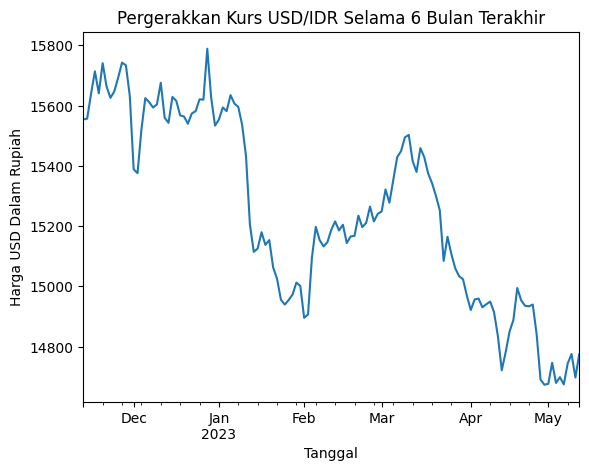

In [23]:
df.plot(ylabel = "Harga USD Dalam Rupiah", legend = False, title = "Pergerakkan Kurs USD/IDR Selama 6 Bulan Terakhir");

Bila kita lihat dari hasil visualisasi, pada saat penulisan ini (Mei 2023) bisa dilihat bahwa harga USD sedang mengalami penurunan yang cukup signifikan. Ini menandakan bahwa Indonesia sedang memiliki peningkatan pada buying power mereka jika mereka bertransaksi dengan Amerika Serikat. Selain itu dengan meningkatnya nilai Rupiah, ini menunjukkan bahwa Indonesia tingkat inflasi di Indonesia sedang membaik pada saat ini.

Kita juga bisa melihat bahwa terdapat semacam pola yang ditunjukkan oleh plot, yang dimana terdapat kecenderungan untuk harga USD mengalami peningkatan yang cukup besar untuk kemudian mengalami mengalami penurunan yang jauh lebih besar daripada tingkat kenaikannya. Oleh karena itu, kita bisa saja membuat perkiraan bahwa harga USD akan mengalami peningkatan yang cukup besar pada beberapa waktu kedepan.

Membicarakan mengenai penurunan besar, terjadi dua titik waktu terjadinya penurunan harga USD: Januari 2023 dan Maret 2023. Jika melihat ke dua bulan tersebut, terdapat beberapa kemungkinan yang bisa membantu menjelaskan penurunan tersebut:

- Untuk penurunan Januari, Amerika Serikat dilaporkan mengalami tingkat inflasi yang sangat tinggi pada bulan tersebut. Lebih spesifiknya, inflasi di Amerika Serikat meningkat sebesar 6.4% jika dibandingkan pada bulan yang sama di tahun sebelumnya. Kenaikkan inflasi tersebut lebih tinggi daripada apa yang diharapkan oleh The Fed.

- Penurunan pada bulan Maret kemungkinan besar disebabkan oleh jatuhnya 3 bank besar di Amerika Serikat seperti Sillicone Valley Bank, Silvergate, dan Credit Suisse. Kejatuhan Sillcone Valley Bank dan Silvergate disebabkan oleh hilangnya likuiditas secara tiba-tiba akibat dari kesalahan proyeksi pergerakan suku bunga. The Fed pada saat membuat peningkatan tinggi terhadap suku bunga sebagai cara untuk memerangi inflasi. Sedangkan Credit Suisse gagal karena pada tahun-tahun belakangan bank tersebut sering terlibat dalam skandal-skandal seperti korupsi, pencucian uang, penghidaran pajak, dan sebagainya.

### Implement it at the webapps

- You can create additional analysis from the data.
- Implement it to the dashboard with at `app.py` dan `index.html`.